In [1]:
from collections import defaultdict
from copy import deepcopy
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from scipy.cluster.hierarchy import dendrogram
from typing import Callable, Dict, List, Set, Tuple

# Report

### Names

Ethan Pedersen

### Report Structure

Similar to project 2, I'm treating the vast majority of this notebook as the report.  The report/notebook is structured as follows:

<ul>
    <li> Helper Code: This section contains the majority of the code I used to run the simulations, generate plots, etc.  You can skip through this if you wish to save time.
    <li> Independent Variables: The independent variables I used.
    <li> Dependent Variables: The dependent variables I calculated.
    <li> Approach for Choosing Initial Adopters: How I chose the early adopters of technology A.
    <li> Approach for Choosing Edges: How I chose edges to add to the network.
    <li> Hypotheses: The various hypotheses I made and tested.
    <li> Graph with 100 Edges, Lambda = 5, and Three Node Types: The tests I ran on the first graph.  At the end is a discussion of how the results impact the validity of my hypotheses.
    <li> Graph with 200 Edges, Lambda = 5, and Three Node Types: The tests I ran on the second graph.  At the end is a discussion of how the results impact the validity of my hypotheses.
    <li> Graph with 200 Edges, Lambda = 5, and Four Node Types: The tests I ran on the third graph.  At the end is a discussion of how the results impact the validity of my hypotheses.
    <li> Graph with 200 Edges, Lambda = 5, and Six Node Types: The tests I ran on the fourth graph.  At the end is a discussion of how the results impact the validity of my hypotheses.
    <li> Graph with 300 Edges, Lambda = 10, and Six Node Types: The tests I ran on the fifth graph.  At the end is a discussion of how the results impact the validity of my hypotheses.
    <li> Conclusion: A final discussion about how the various results impact my hypotheses.
    <li> Future Work: A brief description of what I would work on next and what I wish I had done differently.
</ul>

### Helper Code

In [2]:
class MixedNetworkFormation:
    def __init__(self, M=None, poisson_lambda = 5, num_edges = 200):
        ### Initialize Algorithm with four types using Equation 3 ###
        if M is None:
            self.M = np.array([[0.4, 0.02, 0.01, 0.03],
                [0.02, 0.4, 0.03, 0.02],
                [0.01, 0.03, 0.4, 0.01],
                [0.03, 0.02, 0.01, 0.4]]) # Mixing matrix
        else: self.M = M

        # Number of node types equals dimension of M matrix
        self.type_list = [i for i in range(len(M))]
        self.color_template = ['y', 'b', 'm', 'c', 'k'] 

        # Create empty graph
        self.G = nx.Graph()
        
        # Run the algorithm
        self._AlgorithmStep1(poisson_lambda)
        self._AlgorithmStep2(num_edges)
        self._AlgorithmStep3()
        self._AlgorithmStep4()

        ### Set graph properties ### 
        self.color_map = self._getColorMap()        

    """ Public methods """
    def getGraph(self): return self.G
    def getGroundTruthColors(self): return self.color_map   
    def getColorTemplate(self): return self.color_template
    def getAverageDegree(self): return(np.average([self.G.degree(n) for n in self.G.nodes]))
    
    """ Private methods """
    ### Graph Helpers 
    def _getColorMap(self):
        color_map = []
        num_colors = len(self.color_template)
        for node in self.G.nodes: 
            color_map.append(self.color_template[self.G.nodes[node]['type']%num_colors])
        return color_map

    ### Algorithm Step 1 ###
    def _AlgorithmStep1(self, poisson_lambda):
        self.PoissonLambda = poisson_lambda
   
    ### Algorithm Step 2 ###
    def _AlgorithmStep2(self, num_edges):
        self.num_edges = num_edges # This is how many edges I want
        self.edgeNumbersDict = self._drawEdgesFromMixingMatrix()
        self.endsByTypeDict = self._countEndsOfEdgesByType()
        self.expectedNumberOfNodes = self._computeExpectedNumberOfNodes()
    def _drawEdgesFromMixingMatrix(self):
        edgeNumbersDict = dict()
        # initialize dictionary
        for type1 in self.type_list:
            for type2 in self.type_list:
                if type2>=type1:
                    edgeNumbersDict[(type1,type2)] = 0
        count = 0
        while count < self.num_edges:
            for type1 in self.type_list:
                for type2 in self.type_list:
                    if np.random.uniform(low=0.0,high=1.0) < self.M[type1][type2]:
                        if type2 >= type1: edgeNumbersDict[(type1,type2)] += 1
                        else: edgeNumbersDict[(type2,type1)] += 1
                        count+=1
        #(edgeNumbersDict)
        #print("There are ", sum([edgeNumbersDict[key] for key in edgeNumbersDict.keys()])," edges in the dictionary")
        return edgeNumbersDict
    def _countEndsOfEdgesByType(self):
        endsByTypeDict = {k: 0 for k in self.type_list} # initialize dictionary
        for type1 in self.type_list:
            for type2 in self.type_list:
                if type2<type1: continue
                if type1 == type2: endsByTypeDict[type1] += self.edgeNumbersDict[(type1,type2)]*2
                else: 
                    endsByTypeDict[type1] += self.edgeNumbersDict[(type1,type2)]
                    endsByTypeDict[type2] += self.edgeNumbersDict[(type1,type2)]
        #print("node ends by type ", endsByTypeDict)
        return endsByTypeDict
    def _computeExpectedNumberOfNodes(self):
        numNodeDict = dict()
        for type in self.type_list:
            n = np.round(self.endsByTypeDict[type]/self.PoissonLambda)
            #print(int(n))
            numNodeDict[type] = int(n)
        return numNodeDict

    ### Algorithm Step 3 ###
    def _AlgorithmStep3(self):
        self.nodeListByTypeAndDegree = self._drawNodesFromTypes()
    def _drawNodesFromTypes(self):
        nodesByDegreeDict = {k: [] for k in self.type_list} # initialize to dictionary of empty lists
        for type in self.type_list:
            nodeList = self._drawNodesByType(type)
            nodesByDegreeDict[type] = nodeList
        #print("nodesByDegreeDict = ", nodesByDegreeDict) 
        return nodesByDegreeDict  
    def _drawNodesByType(self,type):
        nodeList = list()
        #print("Trying to get ", self.endsByTypeDict[type]," total degrees")
        while len(nodeList) != self.expectedNumberOfNodes[type]:
            if len(nodeList) < self.expectedNumberOfNodes[type]:
                node = np.random.poisson(lam=self.PoissonLambda)
                if node==0: continue
                nodeList.append(node)
            #print("Number of nodes in node set ", type, " is ", sum(nodeList))
            if len(nodeList) > self.expectedNumberOfNodes[type]:
                nodeList.pop(0)
                #print("Number of nodes in node set ", type, " is ", sum(nodeList))
        #print("Length of nodeList for type ",type, " = ",len(nodeList))
        return nodeList

    ### Algorithm Step 4 ###
    def _AlgorithmStep4(self):
        self._addNodesToGraph()
        self._addEdgesToGraph() # Requires nodes to be added to graph
    def _addNodesToGraph(self):
        # Make the node list into a a format with node_id by type
        nodeList = []
        nodeID = 0
        for type in self.type_list:
            for nodeDegree in self.nodeListByTypeAndDegree[type]:
                nodeList.append((nodeID, {"type":type, "degree":nodeDegree}))
                nodeID += 1
        #print("node list is ", nodeList)
        self.G.add_nodes_from(nodeList)
        return nodeList
    def _addEdgesToGraph(self):
        #print("Adding edges to graph")
        for edge_type in self.edgeNumbersDict.keys():
            type1 = edge_type[0]; type2 = edge_type[1]
            while self.edgeNumbersDict[edge_type] > 0 :
                free_agents1 = self._getFreeAgents(type1)
                free_agents2 = self._getFreeAgents(type2)
                if free_agents1 == [] or free_agents2 == []: break
                node1 = free_agents1[np.random.randint(0,len(free_agents1))]
                neighbors_of_node = [n for n in self.G[node1]]
                neighbors_of_node.append(node1) # If same type, don't allow self loops
                possible_neighbors = list(set(free_agents2) - set(neighbors_of_node))
                if possible_neighbors == []: break
                index2 = np.random.randint(0,high=len(possible_neighbors))
                node2 = possible_neighbors[index2]
                self.G.add_edge(node1,node2)
                self.edgeNumbersDict[edge_type] -= 1
                self._decrementRemainingDegree(node1)
                self._decrementRemainingDegree(node2)
        #print("Done adding edges to graph")
        return 
    def _getFreeAgents(self,type):
        # return agents of specified type that have free stubs
        #print("Graph node info is ", self.G.nodes.data())
        nodes = []
        for node in self.G.nodes.data():
            node_info = list(node)
            node_index = node_info[0]
            node_degree = node_info[1]['degree']
            node_type = node_info[1]['type']
            if node_type == type and node_degree > 0: nodes.append(node_index)
        return nodes
    def _decrementRemainingDegree(self,node_index):
        # subtract one from the nodeList
        self.G.nodes[node_index]['degree'] -= 1
        #print("node ", node_index, " now has remaining degree ", self.G.nodes[node_index]['degree'], "\n\n")
        return

In [3]:
class graphHandler:
    def __init__(self, G, colormap, use_pydot = True):
        self.G = G
        self.color_template = self.color_template = ['y', 'b', 'm', 'c', 'k'] 
        self.color_map = colormap
        if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')
        else: self.pos = nx.nx_agraph.graphviz_layout(self.G,prog='neato')
    ####################
    ## Public methods ##
    ####################
    def getGraph(self): return self.G
    def showGraph(self,agent_colors = None,title = None):
        if agent_colors == None: agent_colors = self.color_map
        if title == None: title = "Network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
    def showLouvainCommunities(self, title = None):
        agent_colors = self._getAgentColors_from_LouvainCommunities()
        if title == None: title = "Louvain communities for network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
    def showDendrogram(self):
        myHandler = DendrogramHandler(self.G)
        Z = myHandler.getLinkMatrix()
        ZLabels = myHandler.getLinkMatrixLabels()
        #plt.figure(figureNumber);plt.clf()
        dendrogram(Z, labels=ZLabels)
        del myHandler
    def show_kCores(self):
        """ Visualize by k-cores. 
        Thanks to [Corralien's response on stackoverflow]
        (https://stackoverflow.com/questions/70297329/visualization-of-k-cores-using-networkx).
        """
        # build a dictionary of k-level with the list of nodes
        kcores = defaultdict(list)
        for n, k in nx.core_number(self.G).items():
            kcores[k].append(n)

        # compute position of each node with shell layout
        pos = nx.layout.shell_layout(self.G, sorted(list(kcores.values())))
        colors = ['black','lightblue','yellow','magenta','olive', 'cyan']
        legend_elements = []

        # draw nodes, edges and labels
        for kcore in sorted(list(kcores.keys()),reverse = True):
            nodes = kcores[kcore]
            nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=colors[kcore%len(colors)])
            label = f"kcore = {kcore}"
            color = colors[kcore%len(colors)]
            legend_elements.append(Line2D([0], [0], marker='o', color=color, label=label,markerfacecolor=color, markersize=15))
        nx.draw_networkx_edges(self.G, pos, width=0.2)
        nx.draw_networkx_labels(self.G, pos)
        plt.title("K-core layout of network")
        plt.legend(handles = legend_elements, loc = 'best')
    def show_partitions(self, partition_list, title = "Network colored by partitions"):
        plt.figure()
        plt.axis('off')
        for i in range(len(partition_list)):
            nx.draw_networkx_nodes(partition_list[i],self.pos,node_color=self.color_template[i%len(self.color_template)], alpha = 0.8)
        for edge in self.G.edges:
            self._draw_edge_by_type(edge, partition_list)
        nx.draw_networkx_labels(self.G,self.pos)
        if len(partition_list) == 0:
            mod = 0
        else:
            mod = nx.algorithms.community.quality.modularity(self.G,partition_list)
        title = title + ": Modularity = " + str(np.round(mod,2))
        plt.title(title)
    
    #####################
    ## Private methods ##
    #####################
    def _getAgentColors_from_LouvainCommunities(self):
        """ Use the Louvain partition method to break the graph into communities """
        # Louvain method pip install python-louvain
        # see https://arxiv.org/pdf/0803.0476.pdf
        # see https://github.com/taynaud/python-louvain
        color_map = self.color_map
        set_of_partitions = nx.community.louvain_communities(self.G)
        print(f"The Louvain algorithm found {len(set_of_partitions)} partitions.")
        partition_number = 0
        for partition in set_of_partitions:
            for node in partition:
                color_map[node] = self.color_template[partition_number%len(self.color_template)]
            partition_number += 1
        return color_map
    def _draw_edge_by_type(self, edge, partition):
        edge_style = 'dashed'
        for part in partition:
            if edge[0] in part and edge[1] in part:
                edge_style = 'solid'
                break
        nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)

In [4]:
# Generic state class
class State:
    def __init__(self, color: str) -> None:
        self.color = color

    def transition(self):
        pass

    def utility(self) -> int:
        pass


# State A
class A(State):
    def __init__(self, color: str = 'cyan') -> None:
        super().__init__(color)

    def transition(self) -> State:
        return self
    
    def utility(self) -> int:
        return 3
    

# State B
class B(State):
    def __init__(self, neighbors: List, color: str = 'blue') -> None:
        super().__init__(color)
        self.neighbors = neighbors

    def transition(self) -> State:
        cumulative_a, cumulative_b = 0, 0

        for neighbor in self.neighbors:
            neighbor_utility = neighbor.prev_state.utility()
            cumulative_a += neighbor_utility if isinstance(neighbor.prev_state, A) else 0
            cumulative_b += neighbor_utility if isinstance(neighbor.prev_state, B) else 0

        return A() if cumulative_a >= cumulative_b else self
    
    def utility(self) -> int:
        return 2

In [5]:
# Agent class (used to represent each node in a graph)
class Agent:
    def __init__(self, initial_state_type: type) -> None:
        assert issubclass(initial_state_type, State)
        self.initial_state_type = initial_state_type
        self.neighbors = []
        self.prev_state, self.curr_state = None, None

    def transition(self) -> None:
        assert self.curr_state is not None
        self.prev_state = self.curr_state
        self.curr_state = self.curr_state.transition()

    def finalize_transition(self) -> None:
        assert self.curr_state is not None
        self.prev_state = self.curr_state

    def add_neighbor(self, neighbor) -> None:
        self.neighbors.append(neighbor)

    def set_initial_state(self) -> None:
        self.curr_state = self._initialize_state()
        self.prev_state = self.curr_state

    def _initialize_state(self) -> State:
        if self.initial_state_type == B:
            return B(neighbors=self.neighbors)
        
        else:
            return A()

In [6]:
# Population class (used to create and handle agents for a graph)
class Population:
    def __init__(self, graph_generator: Callable[[None], nx.Graph], 
                 early_adopters_generator: Callable[[nx.Graph], List[object]]) -> None:
        self.graph_generator = graph_generator
        self.graph = self.graph_generator()
        self.early_adopters_generator = early_adopters_generator
        self.early_adopters = self.early_adopters_generator(self.graph)
        self.agents = self._initialize_agents()

    def _initialize_agents(self) -> Dict:
        agents, nodes = {}, self.graph.nodes

        for node in nodes:
            if node in self.early_adopters:
                initial_state_type = A

            else:
                initial_state_type = B

            agents[node] = Agent(initial_state_type)

        for node in nodes:
            neighbors = self.graph.neighbors(node)

            for neighbor in neighbors:
                neighbor_agent = agents[neighbor]
                agents[node].add_neighbor(neighbor_agent)

            agents[node].set_initial_state()

        return agents
    
    def transition(self) -> None:
        # Calculate what each node's next state should be
        for agent in self.agents.values():
            agent.transition()

        # Apply/set the next states
        for agent in self.agents.values():
            agent.finalize_transition()
    
    def n_agents_with_type(self, state_type: type) -> int:
        assert issubclass(state_type, State)

        n_with_type = 0

        for agent in self.agents.values():
            n_with_type += 1 if isinstance(agent.curr_state, state_type) else 0

        return n_with_type
    
    def nodes_with_type(self, state_type: type) -> List[Tuple[object, str]]:
        nodes_with_type = [(node_label, agent.curr_state.color) for node_label, agent 
                           in self.agents.items() if isinstance(agent.curr_state, state_type)]
        
        return nodes_with_type
    
    def reset(self) -> None:
        self.graph = self.graph_generator()
        self.early_adopters = self.early_adopters_generator(self.graph)
        self.agents = self._initialize_agents()

In [7]:
# Simulation class (used to run simulations on a population and track results)
class Simulation:
    def __init__(self, name: str, population: Population, layout: Dict, n_iterations: int = 50, n_trials: int = 1) -> None:
        self.name = name
        self.population = population
        self.layout = layout
        self.n_iterations = n_iterations
        self.n_trials = n_trials
        self.a_counts, self.b_counts = [], []

    def run(self, show_final_plot: bool = True) -> None:
        node_colors = []
        self.a_counts, self.b_counts = [], []
        self.clustering_coefficients, self.times_to_stop, self.agent_percentages = [], [], []

        for _ in range(self.n_trials):
            a_counts, b_counts = [], []

            for _ in range(self.n_iterations):
                for state_type, count_array in [(A, a_counts), (B, b_counts)]:
                    n_agents_with_type = self.population.n_agents_with_type(state_type)
                    count_array.append(n_agents_with_type)

                if show_final_plot and len(node_colors) < self.n_iterations:
                    colors = []

                    for state_type in [A, B]:
                        nodes_with_type = self.population.nodes_with_type(state_type)
                        colors.extend(nodes_with_type)

                    node_colors.append(colors)

                self.population.transition()

            # Keep track of the two states
            self.a_counts.append(a_counts)
            self.b_counts.append(b_counts)

            # Reset the population for the next trial (if there is a next trial)
            self.population.reset()

        if show_final_plot:
            graph = self.population.graph

            color_mapping = {}
            colors = node_colors[-1]

            for node, color in colors:
                color_mapping[node] = color

            nx.draw(graph, self.layout, with_labels=True, node_color=[color_mapping[node] for node in graph.nodes])
            plt.show()

        return

    def plot(self, show_iqr: bool = False) -> None:
        assert len(self.a_counts) == len(self.b_counts) == self.n_trials
        assert len(self.a_counts[0]) == len(self.b_counts[0]) == self.n_iterations

        x_vals = range(self.n_iterations)

        a_mean = np.mean(self.a_counts, axis=0)
        plt.plot(x_vals, a_mean, label='A', color='cyan')
        b_mean = np.mean(self.b_counts, axis=0)
        plt.plot(x_vals, b_mean, label='B', color='blue')

        if show_iqr:
            a_25 = np.percentile(self.a_counts, 25, axis=0)
            a_75 = np.percentile(self.a_counts, 75, axis=0)
            plt.fill_between(x_vals, a_25, a_75, color='cyan', alpha=0.5)
            b_25 = np.percentile(self.b_counts, 25, axis=0)
            b_75 = np.percentile(self.b_counts, 75, axis=0)
            plt.fill_between(x_vals, b_25, b_75, color='blue', alpha=0.5)

        plt.legend(loc='best')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.title('Number of Nodes in the A and B States, Over Time')
        plt.show()

In [8]:
def eigenvector_centrality(graph: nx.Graph, log: bool = False) -> Dict[Tuple, float]:
    centrality, sorted_centrality = nx.eigenvector_centrality(graph), {}

    for node, centrality in sorted(centrality.items(), key=lambda x: x[1], reverse=True):
        if log:
            print(f'Node {node}: {centrality}')
        sorted_centrality[node] = centrality

    return sorted_centrality

In [9]:
def betweenness(graph: nx.Graph, log: bool = False) -> Dict[Tuple, float]:
    betweenness, sorted_betweenness = nx.edge_betweenness_centrality(graph), {}

    for edge, betweenness in sorted(betweenness.items(), key=lambda x: x[1], reverse=True):
        if log:
            print(f'Edge {edge}: {betweenness}')
        sorted_betweenness[edge] = betweenness

    return sorted_betweenness

In [10]:
def choose_early_adopters(graph: nx.Graph, node_percentage: float = 0.05) -> Set[object]:
    sorted_centrality = eigenvector_centrality(graph)
    n_nodes_as_early_adopters = int(round(graph.number_of_nodes() * node_percentage))
    early_adopters = set([node for node in list(sorted_centrality.keys())[:n_nodes_as_early_adopters]])

    assert len(early_adopters) == n_nodes_as_early_adopters

    return early_adopters

In [11]:
def choose_early_adopters_by_community(graph: nx.Graph, node_percentage: float = 0.05) -> Set[object]:
    sorted_centrality = eigenvector_centrality(graph)
    n_nodes_as_early_adopters = int(round(graph.number_of_nodes() * node_percentage))
    communities = nx.community.louvain_communities(graph)
    early_adopters = set()

    while len(early_adopters) < n_nodes_as_early_adopters:
        for community in communities:
            nodes_with_centralities = [(node, sorted_centrality[node]) for node in community]
            nodes_with_centralities.sort(key=lambda x: x[1], reverse=True)

            for node, _ in nodes_with_centralities:
                if node not in early_adopters:
                    early_adopters.add(node)
                    break

            if len(early_adopters) >= n_nodes_as_early_adopters:
                break

    assert len(early_adopters) == n_nodes_as_early_adopters

    return early_adopters

In [12]:
def add_edges(graph: nx.Graph, early_adopters: Set[object], edge_percentage: float = 0.1, 
              weight_by_centrality: bool = False, infiltrate_with_min: bool = True, 
              reverse_betweenness: bool = False, recalculate_graph_metrics: bool = False, 
              consider_edge_once: bool = True, reverse_weights: bool = False) -> nx.Graph:
    n_edges_to_add, n_edges_added = int(round(graph.number_of_edges() * edge_percentage)), 0
    new_graph, edges_considered = deepcopy(graph), set()
    existing_edges = set(graph.edges())
    sorted_centrality = eigenvector_centrality(graph)
    sorted_betweenness = betweenness(graph)

    while n_edges_added < n_edges_to_add:
        edges_to_iterate_over = reversed(list(sorted_betweenness.keys())) if reverse_betweenness else list(sorted_betweenness.keys())
        
        for edge in edges_to_iterate_over:
            left_node, right_node = edge

            if (consider_edge_once and edge in edges_considered) or (left_node in early_adopters and right_node in early_adopters):
                continue

            weights = [sorted_centrality[left_node], sorted_centrality[right_node]] if weight_by_centrality else None
            if weights is not None and reverse_weights:
                weights = [1 - weight for weight in weights]
            node_to_use = right_node if left_node in early_adopters else (left_node if right_node in early_adopters else random.choices([left_node, right_node], weights)[0])
            weights = [sorted_centrality[adopter] for adopter in early_adopters] if weight_by_centrality else None
            if weights is not None and reverse_weights:
                weights = [1 - weight for weight in weights]
            node_to_add_edge_to = left_node if left_node in early_adopters else (right_node if right_node in early_adopters else random.choices(list(early_adopters), weights)[0])
            neighbors, neighbor_to_use = list(nx.neighbors(graph, node_to_use)), None
            if node_to_use not in early_adopters:
                neighbors.append(node_to_use)
            centrality_metric = np.inf if infiltrate_with_min else -np.inf

            for neighbor in neighbors:
                centrality = sorted_centrality[neighbor]
                edge_already_exists = (neighbor, node_to_add_edge_to) in existing_edges or (node_to_add_edge_to, neighbor) in existing_edges

                if neighbor not in early_adopters and not edge_already_exists and ((infiltrate_with_min and centrality < centrality_metric) or (not infiltrate_with_min and centrality > centrality_metric)):
                    centrality_metric, neighbor_to_use = centrality, neighbor

            if neighbor_to_use is not None:
                new_graph.add_edge(neighbor_to_use, node_to_add_edge_to)
                existing_edges.add((neighbor_to_use, node_to_add_edge_to))
                n_edges_added += 1

                if recalculate_graph_metrics:
                    sorted_centrality = eigenvector_centrality(new_graph)
                    sorted_betweenness = betweenness(new_graph)
                    edges_considered.add(edge)
                    break

            edges_considered.add(edge)

            if n_edges_added >= n_edges_to_add:
                break

    assert new_graph.number_of_edges() == graph.number_of_edges() + n_edges_to_add

    return new_graph

In [13]:
def monte_carlo(graph: nx.Graph, early_adopters: Set[object], edge_percentage: float = 0.1) -> nx.Graph:
    n_edges_to_add, n_edges_added = int(round(graph.number_of_edges() * edge_percentage)), 0
    existing_edges = set(graph.edges())
    nodes = list(graph.nodes)
    new_graph = deepcopy(graph)

    while n_edges_added < n_edges_to_add:
        left_node, right_node = random.choices(nodes)[0], random.choices(list(early_adopters))[0]
        edge_already_exists = (left_node, right_node) in existing_edges or (right_node, left_node) in existing_edges

        if not edge_already_exists:
            new_graph.add_edge(left_node, right_node)
            existing_edges.add((left_node, right_node))
            n_edges_added += 1

    assert new_graph.number_of_edges() == graph.number_of_edges() + n_edges_to_add
        
    return new_graph

In [65]:
def graph_metrics(graph: nx.Graph) -> None:
    average_clustering_coefficient = nx.average_clustering(graph)
    assortativity = nx.degree_assortativity_coefficient(graph)
    modularity = nx.community.modularity(graph, nx.community.louvain_communities(graph))
    average_shortest_path_length = nx.average_shortest_path_length(graph)
    degrees = dict(graph.degree()).values()
    average_degree = sum(degrees) / len(degrees)
    diameter = nx.diameter(graph)
    density = nx.density(graph)

    print(f'Average clustering coefficient: {average_clustering_coefficient}')
    print(f'Assortativity: {assortativity}')
    print(f'Modularity: {modularity}')
    print(f'Average shortest path length: {average_shortest_path_length}')
    print(f'Average degree: {average_degree}')
    print(f'Diameter: {diameter}')
    print(f'Density: {density}')

### Independent Variables

I used the variables given in the specs from projects 2 and 3.  Specifically, the rewards for states A and B (a and b) are 3 and 2, respectively.  I only add 5% of a graph's nodes as early adopters and 10% of a graph's total edges.  I used the Girvan-Newman algorithm to calculate edge betweenness.  I also used the specified number of edges, number of node types, and lambda values for each network.

Additionally, for each graph, I used a mixing matrix where the diagonal values are always 0.8 and all other values are 0.2.  I chose these values because they help create distinct communities while permitting a fair amount of connecting edges between communities.

Finally, because my approach involves randommness, I run each simulation for 1000 trials, where each trial lasts for 50 time steps (in order to give complex contagion enough time to spread to the entire network, if possible).

### Dependent Variables

For each network, I calculate the average clustering coefficient, assortativity, modularity (via Louvain communities), average shortest path length, average degree, diameter, and density.  I also show the rate of spread via time series plots.

### Approach for Choosing Initial Adopters

I decided to use eigenvector centrality to select initial adopters.  Based on our class discussions, degree centrality does not seem as effective as eigenvector centrality.  Furthermore, katz centrality seems like it was designed to fix issues with eigenvector centrality on directed graphs.  However, as we are dealing with undirected graphs, this felt unnecessary.  Finally, page rank was described as an adjustment to katz centrality; since I did not choose katz centrality, this also felt unnecessary.

Additionally, I tested two different approaches for identifying early adopters.  In the default implementation, I simply choose nodes with the largest centrality.  In the second implementation, I make sure to choose nodes from as many communities as possible (using the Louvain algorithm), where the nodes have the largest centrality within their community.

### Approach for Choosing Edges

I will do my best to explain my approach, but the main code can be found in the add_edges function.  The steps are the following:

<ol>
    <li> I create a deep copy of the original graph that is used as the new graph.
    <li> I calculate edge betweenness (using the Girvan-Newman algorithm).
    <li> I iterate through the edges, either in decreasing betweenness order (i.e. I check the edges with the largest betweenness first) or increasing betweenness order.  I initially thought that using edges with the largest betweenness would be better, but I was not entirely sure.
    <li> If an edge contains nodes that are both early adopters, I ignore it.
    <li> If I have already considered an edge, I sometimes ignore it (this is another parameter that I was not sure about).
    <li> If an edges contains one early adopter, I add a new edge to that adopter node.  Otherwise, I randomly choose an early adopter (possibly weighted by centrality) to add an edge to.  For the other node to add an edge to (i.e. a non-adopter), I examine both the non-adopter node in the existing edge and its neighbors.  From this set of non-adopter nodes, I choose the node with either the smallest centrality or largest centrality (this is another parameter I was not sure about, so I played around with it).
    <li> Once an edge is added to the new graph, I optionally recalculate both centrality and betweenness (again, I was not sure if this would be effective or not).
    <li> Once the allowed number of edges are added, I return the new graph.
</ol>

I also briefly used the code from the monte_carlo function, though it is not my main approach.  It works simply by randomly creating edges between non-adopters and early adopters, until the allowed number of edges are added.

### Hypotheses

Each graph is formed non-determinitistically, so for this project I would like to make a broad set of hypotheses (instead of making hypotheses for each graph).  For each graph, I will gather evidence in order to evaluate the hypotheses.

<ol>
    <li> I hypothesize that choosing early adopters with the largest centrality in their own community (instead of choosing nodes with the overall largest centrality values) will be more effective.  This is for two reasons: (1) as we discussed in class, complex contagion tends to work well within clusters but not between clusters, and (2) nodes with large centrality can potentially persuade more nodes to adopt technology A.
    <li> I hypothesize that, when randomly choosing an early adopter to add an edge to, weighting by centrality will at least be slightly more effective than uniform random sampling.  Again, this is because nodes with large centrality can potentially persuade more nodes to adopt technology A, so weighting by centrality will encourage random sampling to gravitate towards the more influential early adopters.
    <li> I hypothesize that iterating through edges in reverse betweenness order (i.e. looking at edges with larger betweenness first) will be more effective.  This is because these edges can be viewed as key connections between communities.
    <li> I hypothesize that choosing non-adopter nodes with larger centrality values will be more effective.  Again, these types of nodes can be viewed as being more influential.
    <li> I hypothesize that recalculating graph metrics as edges are added will probably not have much of an effect on the spread of complex contagion.  Since we are only adding a small number of extra edges, I doubt the metrics would change enough to significantly impact anything.
    <li> I hypothesize that only considering an edge once will also not have a significant impact on spread.  Since the graph is not small and we are only adding an extra 10% of the edges, there should be plenty of edges to consider.
    <li> I hypothesize that the last two graphs (the ones with six node types), and especially the final graph (since its lambda is double the lambda values of the other graphs), will be the most difficult for complex contagion.
</ol>

### Graph with 100 Edges, Lambda = 5, and Three Node Types

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_13625/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


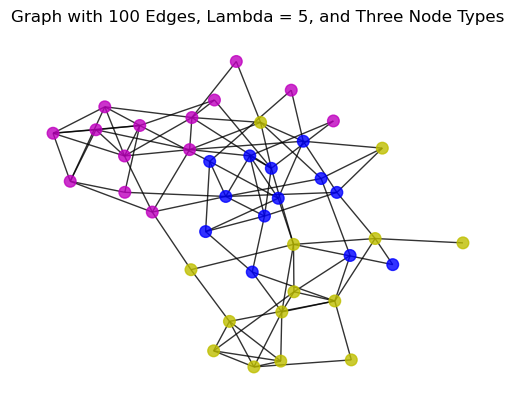

In [33]:
M = np.array([[0.8, 0.2, 0.2],
              [0.2, 0.8, 0.2],
              [0.2, 0.2, 0.8]])
graph_1 = MixedNetworkFormation(M=M, poisson_lambda=5, num_edges=100)
graph_1_handler = graphHandler(graph_1.getGraph(), graph_1.getGroundTruthColors(), use_pydot=True)
graph_1_handler.showGraph(title='Graph with 100 Edges, Lambda = 5, and Three Node Types')

Early adopters by largest centrality value

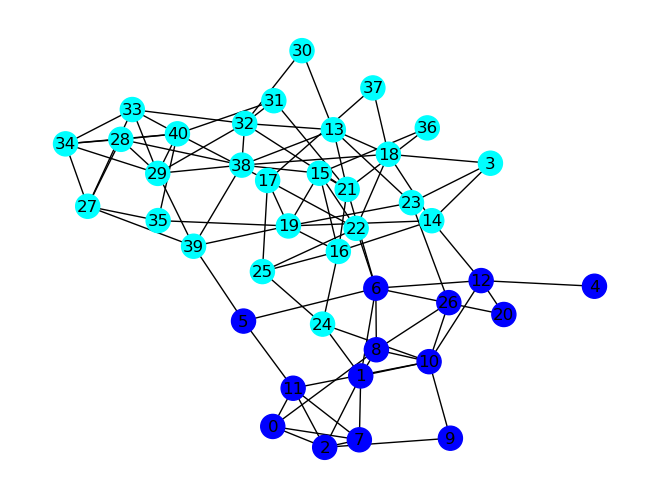

In [34]:
early_adopters = choose_early_adopters(graph_1.getGraph())
population = Population(graph_1.getGraph, lambda _: early_adopters)
graph_1_sim = Simulation('graph_1', population, graph_1_handler.pos)
graph_1_sim.run()

Early adopters by largest centrality value within communities

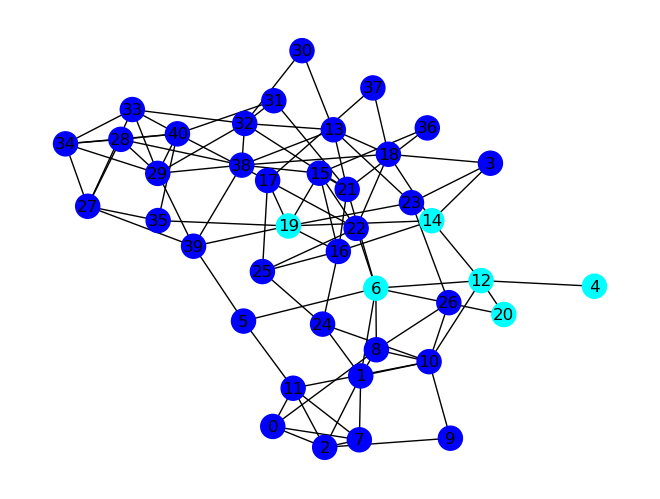

In [35]:
early_adopters = choose_early_adopters_by_community(graph_1.getGraph())
population = Population(graph_1.getGraph, lambda _: early_adopters)
graph_1_sim = Simulation('graph_1', population, graph_1_handler.pos)
graph_1_sim.run()

No weights

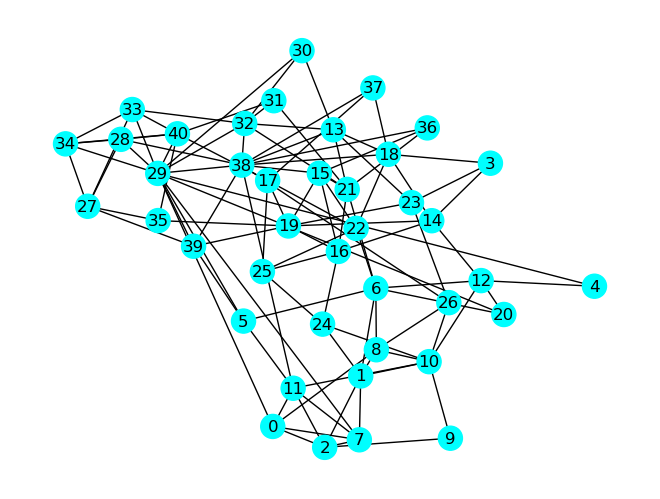

In [37]:
early_adopters = choose_early_adopters(graph_1.getGraph())
population = Population(lambda: add_edges(graph_1.getGraph(), early_adopters, weight_by_centrality=False), lambda _: early_adopters)
graph_1_sim = Simulation('graph_1', population, graph_1_handler.pos, n_trials=1000)
graph_1_sim.run()

Weights

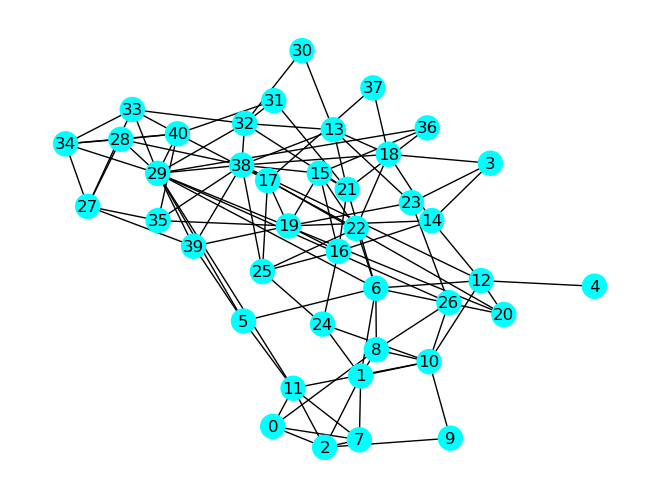

In [38]:
early_adopters = choose_early_adopters(graph_1.getGraph())
population = Population(lambda: add_edges(graph_1.getGraph(), early_adopters, weight_by_centrality=True), lambda _: early_adopters)
graph_1_sim = Simulation('graph_1', population, graph_1_handler.pos, n_trials=1000)
graph_1_sim.run()

Check edges in regular betweenness order (i.e. edges with smaller betweenness values first)

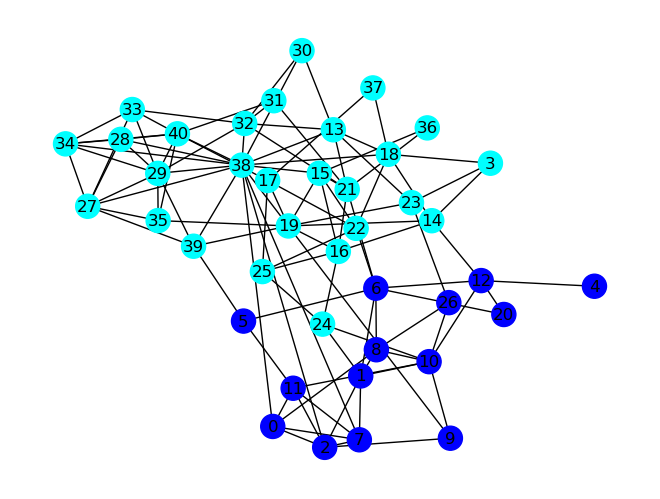

In [39]:
early_adopters = choose_early_adopters(graph_1.getGraph())
population = Population(lambda: add_edges(graph_1.getGraph(), early_adopters, reverse_betweenness=True), lambda _: early_adopters)
graph_1_sim = Simulation('graph_1', population, graph_1_handler.pos, n_trials=1000)
graph_1_sim.run()

Choose non-adopters with larger centrality values

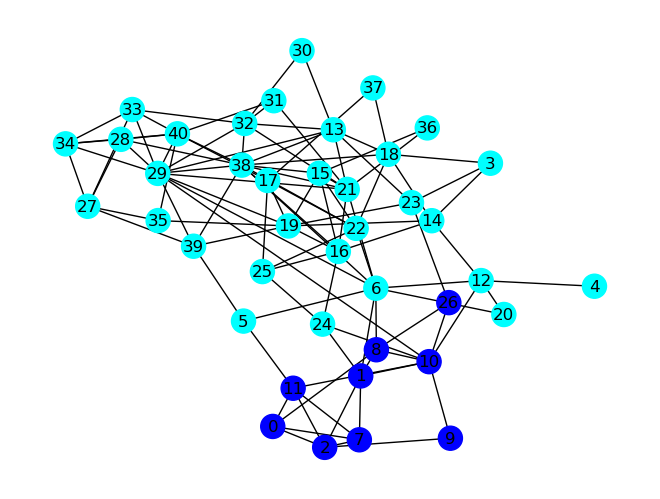

In [40]:
early_adopters = choose_early_adopters(graph_1.getGraph())
population = Population(lambda: add_edges(graph_1.getGraph(), early_adopters, infiltrate_with_min=False), lambda _: early_adopters)
graph_1_sim = Simulation('graph_1', population, graph_1_handler.pos, n_trials=1000)
graph_1_sim.run()

Recalculate graph metrics

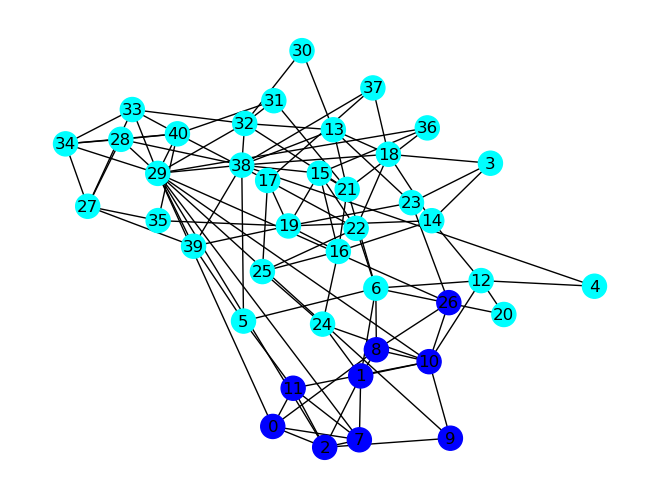

In [41]:
early_adopters = choose_early_adopters(graph_1.getGraph())
population = Population(lambda: add_edges(graph_1.getGraph(), early_adopters, recalculate_graph_metrics=True), lambda _: early_adopters)
graph_1_sim = Simulation('graph_1', population, graph_1_handler.pos, n_trials=1000)
graph_1_sim.run()

Consider an edge more than once

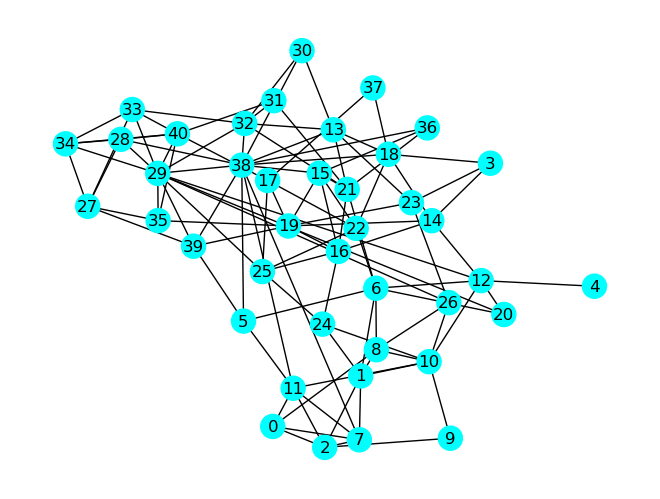

In [42]:
early_adopters = choose_early_adopters(graph_1.getGraph())
population = Population(lambda: add_edges(graph_1.getGraph(), early_adopters, consider_edge_once=False), lambda _: early_adopters)
graph_1_sim = Simulation('graph_1', population, graph_1_handler.pos, n_trials=1000)
graph_1_sim.run()

Based on the previous observations, here are the results with the best parameters:

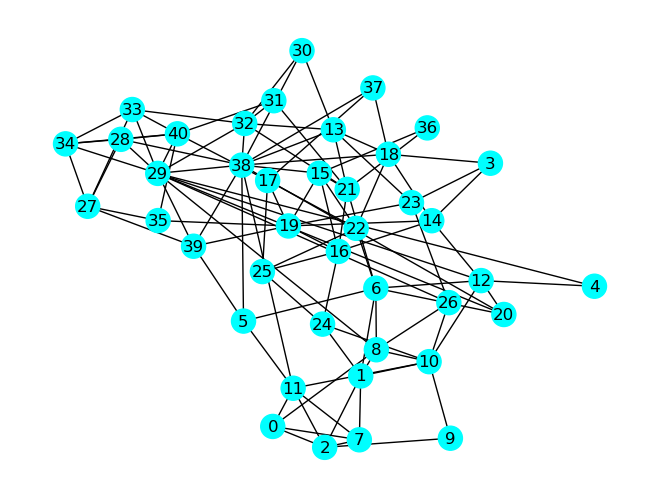

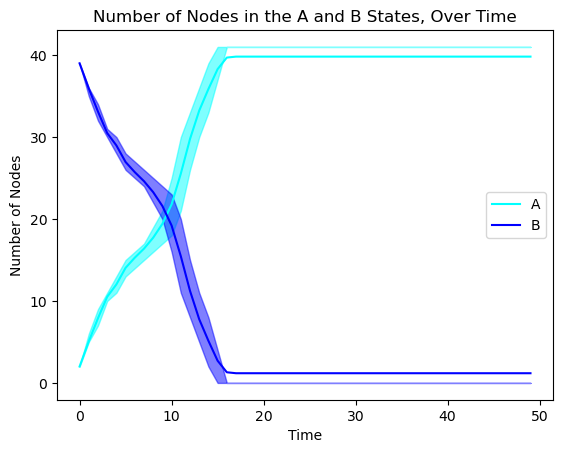

In [43]:
early_adopters = choose_early_adopters(graph_1.getGraph())
population = Population(lambda: add_edges(graph_1.getGraph(), early_adopters), lambda _: early_adopters)
graph_1_sim = Simulation('graph_1', population, graph_1_handler.pos, n_trials=1000)
graph_1_sim.run()
graph_1_sim.plot(show_iqr=True)

In [67]:
graph_metrics(graph_1.getGraph())

Average clustering coefficient: 0.2970963995354239
Assortativity: -0.12668277528477648
Modularity: 0.500759548611111
Average shortest path length: 2.823170731707317
Average degree: 4.682926829268292
Diameter: 6
Density: 0.11707317073170732


The graph metrics are shown in the cell directly above this one.  Additionally, we can see that, with the seemingly optimal parameters, complex contagion spreads to most, and in some cases, all of the network (see the plots from two cells above this one); it also spreads relatively quickly (it reached peak infection after approximately 16 time steps).

Given the results for this graph, I will discuss my hypotheses:

<ol>
    <li> It looks like the first hypothesis is incorrect.  At least for this particular network, it looks like choosing nodes with the overall largest centrality values is more effective.  I am not sure why this would be more effective than choosing influential nodes from each community (especially because a modularity of about 0.5 seems somewhat large); I will wait to see how early adopters affect the other graphs.
    <li> It is difficult to say for sure, but it appears that this hypothesis is also incorrect.  Weighting by centrality did not seem to impact the spread of complex contagion.  If I had to speculate about why this is, I would probably say that the centrality weights are similar enough to the point where weighted random selection is very similar to uniform random sampling.  However, I would have to check the specific weight values to confirm this.
    <li> Based on the evidence, I would say that this hypothesis is correct.  It seems that focusing on edges with larger betweenness values is more effective because they can be viewed as key connections between communities.  Improving connections between communities likely bolsters the spread of complex contagion.
    <li> I would say that this hypothesis is definitely incorrect.  While I would like to see how the other networks are impacted, I believe that a possible explanation as to why choosing nodes with smaller centrality values is more effective is because they require fewer edges to early adopters in order to convert to technology A (i.e. they probably do not have many neighbors, so they might only need one or two connections to an early adopter).
    <li> It appears that this hypothesis is also incorrect.  If anything, it looks like recalcuating graph metrics negatively impacted the spread of complex contagion (plus the simulation took longer to complete).
    <li> I would say that this hypothesis is correct.  Considering an edge only once did not appear to significantly change the spread of contagion.
    <li> The final hypothesis does not apply to this graph (only the last two graphs).
</ol>

### Graph with 200 Edges, Lambda = 5, and Three Node Types

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_13625/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


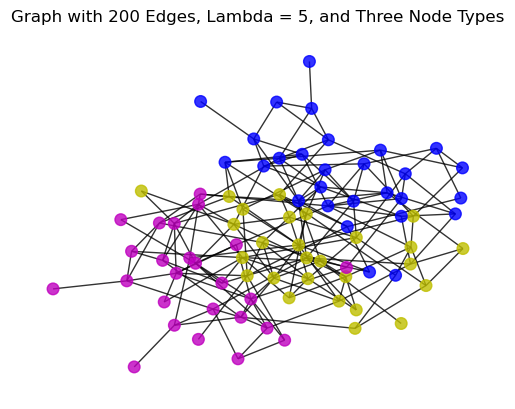

In [45]:
M = np.array([[0.8, 0.2, 0.2],
              [0.2, 0.8, 0.2],
              [0.2, 0.2, 0.8]])
graph_2 = MixedNetworkFormation(M=M, poisson_lambda=5, num_edges=200)
graph_2_handler = graphHandler(graph_2.getGraph(), graph_2.getGroundTruthColors(), use_pydot=True)
graph_2_handler.showGraph(title='Graph with 200 Edges, Lambda = 5, and Three Node Types')

Early adopters by largest centrality value

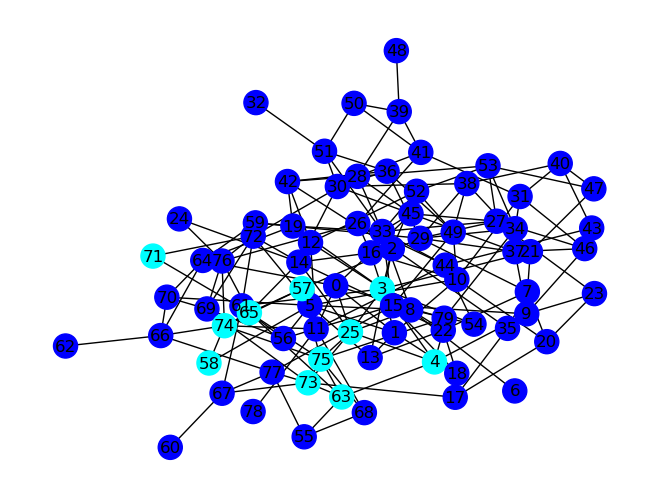

In [46]:
early_adopters = choose_early_adopters(graph_2.getGraph())
population = Population(graph_2.getGraph, lambda _: early_adopters)
graph_2_sim = Simulation('graph_2', population, graph_2_handler.pos)
graph_2_sim.run()

Early adopters by largest centrality value within communities

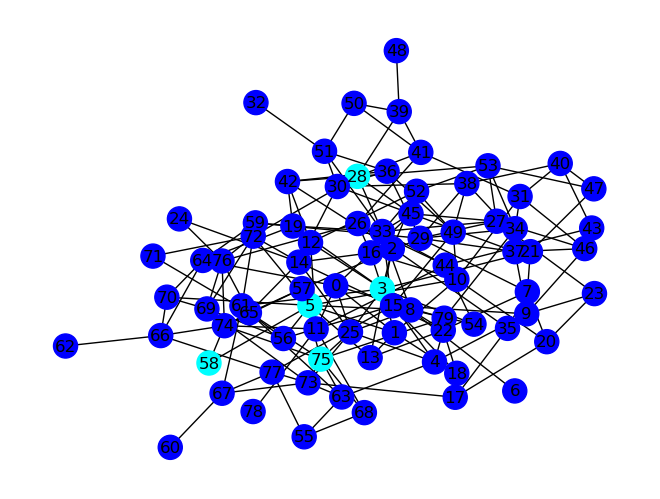

In [47]:
early_adopters = choose_early_adopters_by_community(graph_2.getGraph())
population = Population(graph_2.getGraph, lambda _: early_adopters)
graph_2_sim = Simulation('graph_2', population, graph_2_handler.pos)
graph_2_sim.run()

No weights

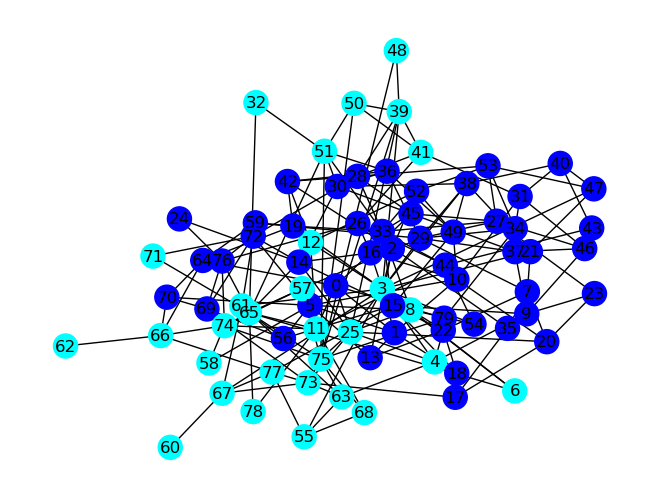

In [51]:
early_adopters = choose_early_adopters(graph_2.getGraph())
population = Population(lambda: add_edges(graph_2.getGraph(), early_adopters, weight_by_centrality=False), lambda _: early_adopters)
graph_2_sim = Simulation('graph_2', population, graph_2_handler.pos, n_trials=1000, n_iterations=50)
graph_2_sim.run()

Weights

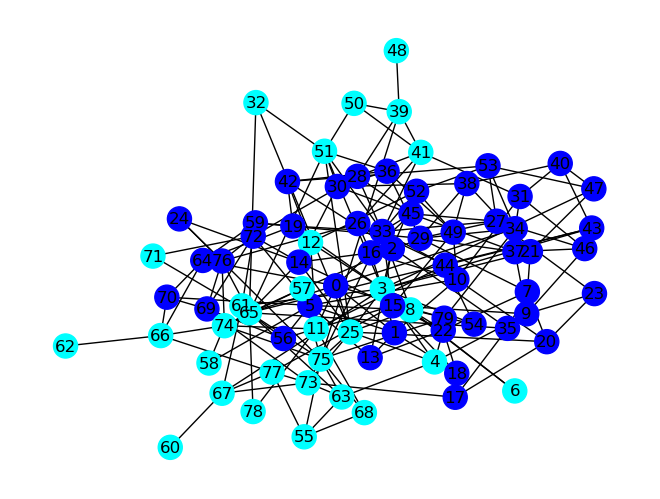

In [49]:
early_adopters = choose_early_adopters(graph_2.getGraph())
population = Population(lambda: add_edges(graph_2.getGraph(), early_adopters, weight_by_centrality=True), lambda _: early_adopters)
graph_2_sim = Simulation('graph_2', population, graph_2_handler.pos, n_trials=1000, n_iterations=50)
graph_2_sim.run()

Check edges in regular betweenness order (i.e. edges with smaller betweenness values first)

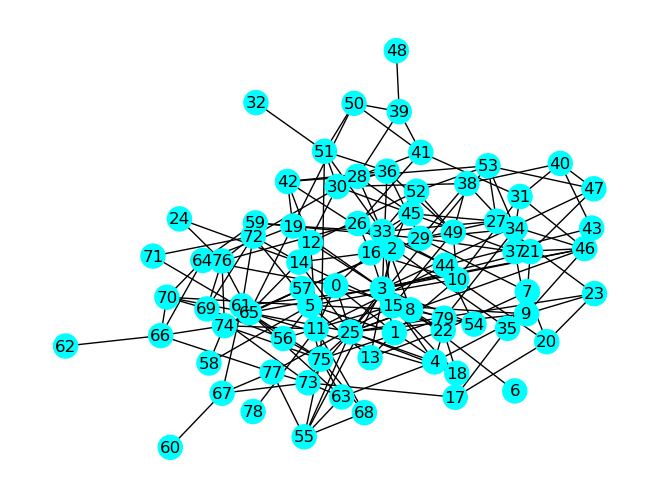

In [53]:
early_adopters = choose_early_adopters(graph_2.getGraph())
population = Population(lambda: add_edges(graph_2.getGraph(), early_adopters, reverse_betweenness=True), lambda _: early_adopters)
graph_2_sim = Simulation('graph_2', population, graph_2_handler.pos, n_trials=1000, n_iterations=50)
graph_2_sim.run()

Choose non-adopters with larger centrality values

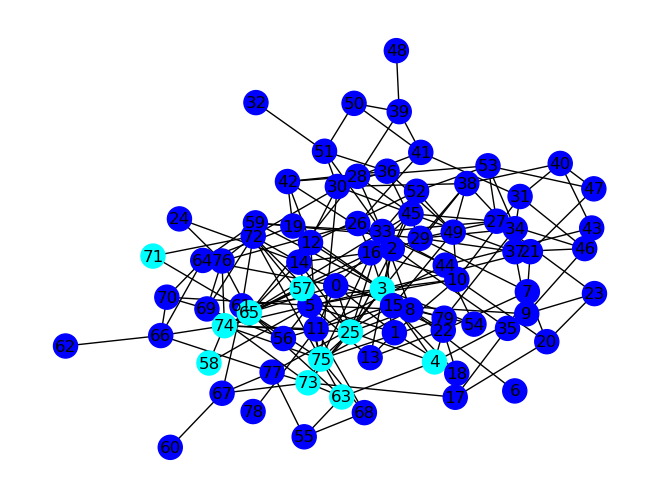

In [55]:
early_adopters = choose_early_adopters(graph_2.getGraph())
population = Population(lambda: add_edges(graph_2.getGraph(), early_adopters, infiltrate_with_min=False), lambda _: early_adopters)
graph_2_sim = Simulation('graph_2', population, graph_2_handler.pos, n_trials=1000, n_iterations=50)
graph_2_sim.run()

Re-calculate graph metrics

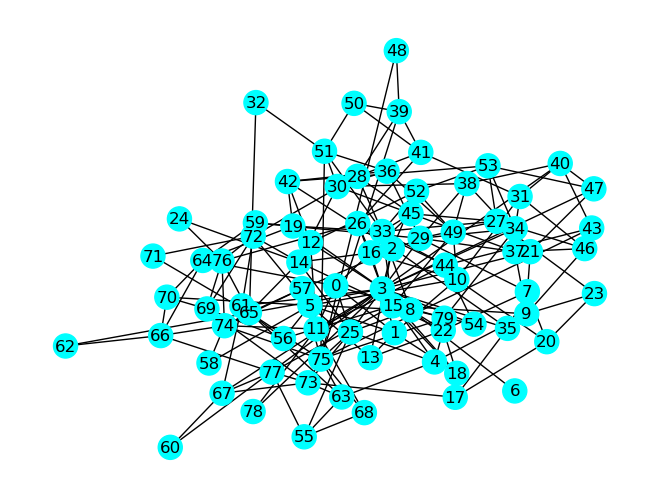

In [56]:
early_adopters = choose_early_adopters(graph_2.getGraph())
population = Population(lambda: add_edges(graph_2.getGraph(), early_adopters, recalculate_graph_metrics=True), lambda _: early_adopters)
graph_2_sim = Simulation('graph_2', population, graph_2_handler.pos, n_trials=1000, n_iterations=50)
graph_2_sim.run()

Consider an edge more than once

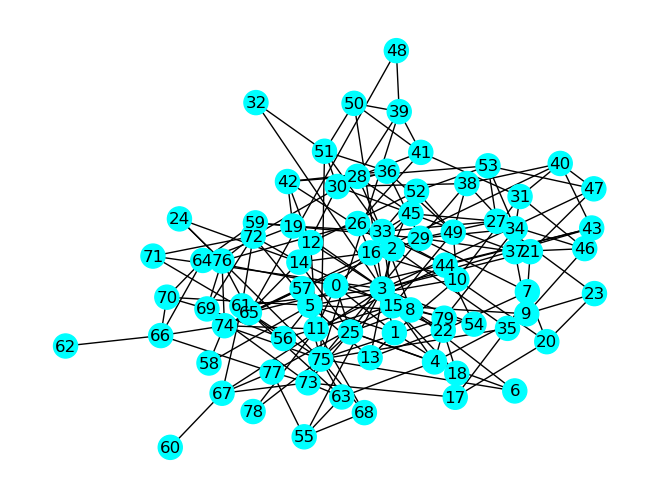

In [58]:
early_adopters = choose_early_adopters(graph_2.getGraph())
population = Population(lambda: add_edges(graph_2.getGraph(), early_adopters, consider_edge_once=False), lambda _: early_adopters)
graph_2_sim = Simulation('graph_2', population, graph_2_handler.pos, n_trials=1000, n_iterations=50)
graph_2_sim.run()

Based on the previous observations, here are the results with the best parameters:

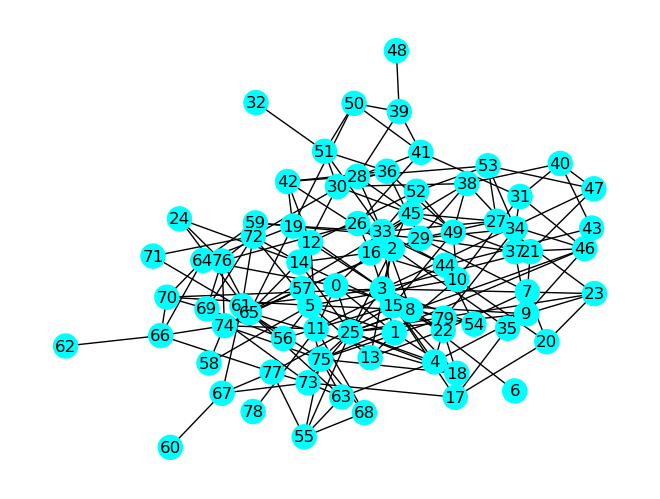

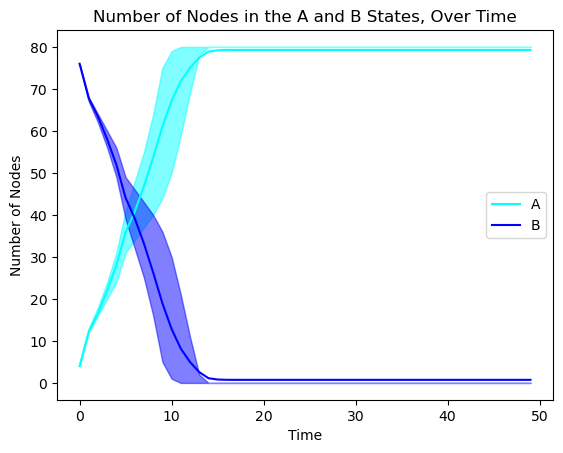

In [61]:
early_adopters = choose_early_adopters(graph_2.getGraph())
population = Population(lambda: add_edges(graph_2.getGraph(), early_adopters, reverse_betweenness=True), lambda _: early_adopters)
graph_2_sim = Simulation('graph_2', population, graph_2_handler.pos, n_trials=1000, n_iterations=50)
graph_2_sim.run()
graph_2_sim.plot(show_iqr=True)

In [66]:
graph_metrics(graph_2.getGraph())

Average clustering coefficient: 0.06665674603174603
Assortativity: -0.050109752273442526
Modularity: 0.43905068525519847
Average shortest path length: 3.089240506329114
Average degree: 4.6
Diameter: 7
Density: 0.05822784810126582


The graph metrics are shown in the cell directly above this one.  Additionally, we can see that, with the seemingly optimal parameters, complex contagion spreads to most, and in some cases, all of the network (see the plots from two cells above this one); it also spreads faster than the first graph (it reached peak infection after approximately 14 time steps).

Given the results for this graph, I will discuss my hypotheses:

<ol>
    <li> It looks like the first hypothesis is still incorrect.  Modularity (about 0.439) is at least smaller than it was for the first graph, so perhaps a possible explanation is that the communities are not very tight-knit, especially considering a low density value, a small clustering coefficient, and a negative assortativity value.  Again, I think I will wait to see the results for the remaining graphs.
    <li> Similar to the first graph, it looks like this hypothesis is incorrect.
    <li> Contrary to the results from the first graph, I would say that this hypothesis is incorrect.  I am not entirely sure why focusing on edges with smaller betweenness would be more effective; I will wait to see the results for the other graphs.
    <li> Also similar to the first graph, I would say that this hypothesis is incorrect.
    <li> Contrary to the first graph, it appears that this hypothesis is correct.  However, similar to the first graph, the simulation took much longer to complete when recalclating graph metrics.
    <li> I would say that this hypothesis is also correct.  Considering an edge only once did not appear to significantly change the spread of contagion.
    <li> The final hypothesis does not apply to this graph (only the last two graphs).
</ol>

### Graph with 200 Edges, Lambda = 5, and Four Node Types

Based on the results from the previous two graphs, and in order to reduce space, I will not test the second, fourth, fifth, and sixth hypotheses.  It appears that weighting by centrality does not have a significant impact, choosing non-adopter nodes with smaller centrality values is much more effective, recalculating graph metrics either negatively impacts or does not impact (i.e. neutral impact) complex contagion but does increase computation time, and considering an edge once does not have a significant impact.

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_13625/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


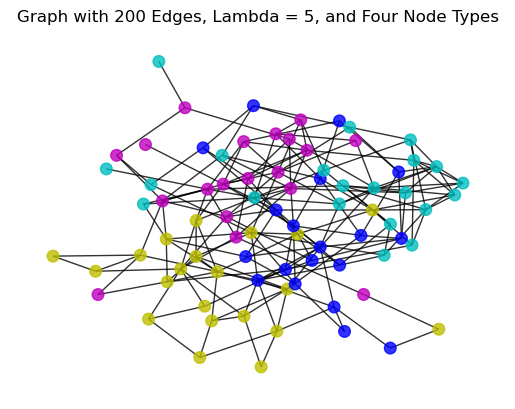

In [68]:
M = np.array([[0.8, 0.2, 0.2, 0.2],
              [0.2, 0.8, 0.2, 0.2],
              [0.2, 0.2, 0.8, 0.2],
              [0.2, 0.2, 0.2, 0.8]])
graph_3 = MixedNetworkFormation(M=M, poisson_lambda=5, num_edges=200)
graph_3_handler = graphHandler(graph_3.getGraph(), graph_3.getGroundTruthColors(), use_pydot=True)
graph_3_handler.showGraph(title='Graph with 200 Edges, Lambda = 5, and Four Node Types')

Early adopters by largest centrality value

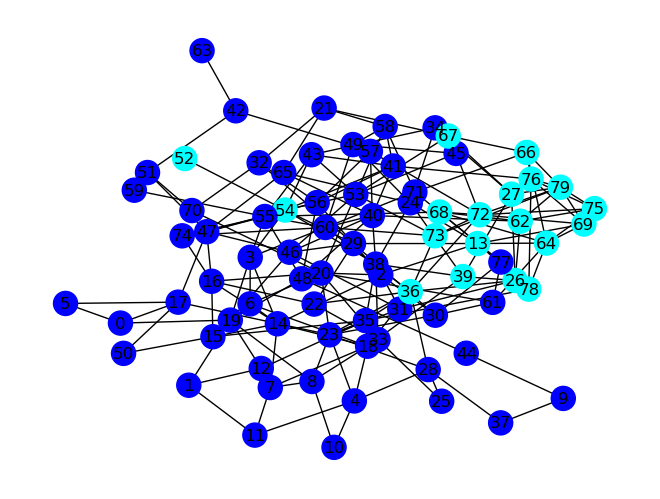

In [69]:
early_adopters = choose_early_adopters(graph_3.getGraph())
population = Population(graph_3.getGraph, lambda _: early_adopters)
graph_3_sim = Simulation('graph_3', population, graph_3_handler.pos)
graph_3_sim.run()

Early adopters by largest centrality value within communities

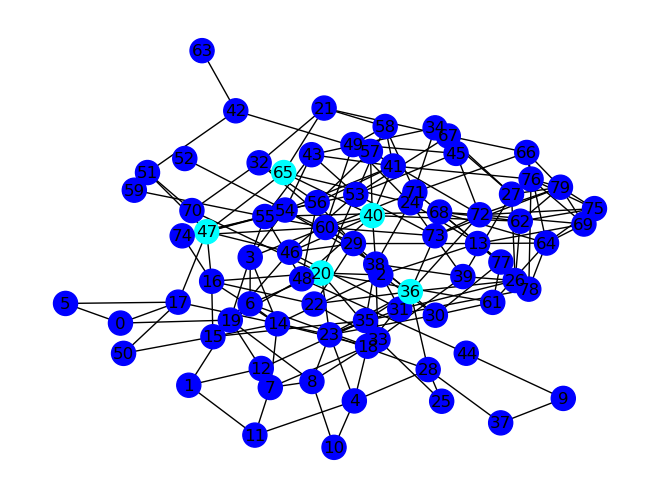

In [70]:
early_adopters = choose_early_adopters_by_community(graph_3.getGraph())
population = Population(graph_3.getGraph, lambda _: early_adopters)
graph_3_sim = Simulation('graph_3', population, graph_3_handler.pos)
graph_3_sim.run()

Check edges in regular betweenness order (i.e. edges with smaller betweenness values first)

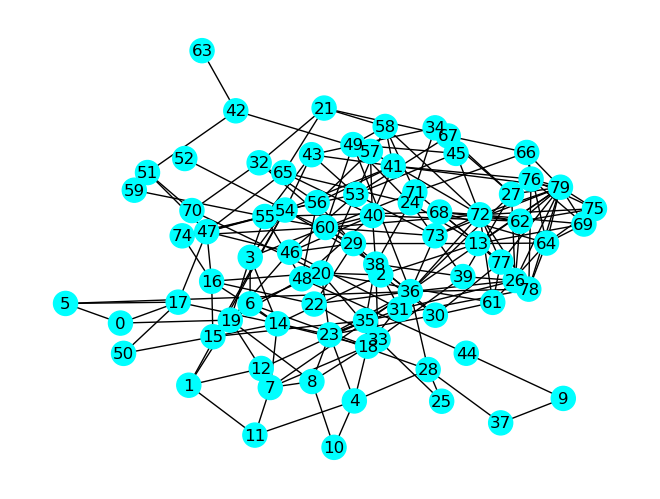

In [72]:
early_adopters = choose_early_adopters(graph_3.getGraph())
population = Population(lambda: add_edges(graph_3.getGraph(), early_adopters, reverse_betweenness=True), lambda _: early_adopters)
graph_3_sim = Simulation('graph_3', population, graph_3_handler.pos, n_trials=1000)
graph_3_sim.run()

Check edges in reverse betweenness order (i.e. edges with larger betweenness values first)

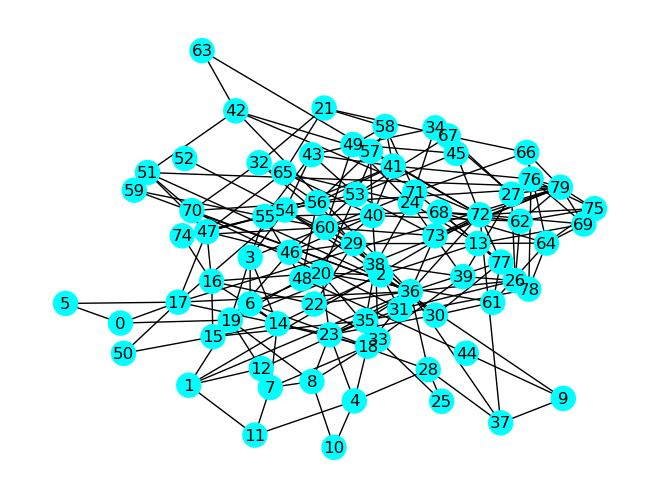

In [73]:
early_adopters = choose_early_adopters(graph_3.getGraph())
population = Population(lambda: add_edges(graph_3.getGraph(), early_adopters, reverse_betweenness=False), lambda _: early_adopters)
graph_3_sim = Simulation('graph_3', population, graph_3_handler.pos, n_trials=1000)
graph_3_sim.run()

Based on the previous observations, here are the results with the best parameters:

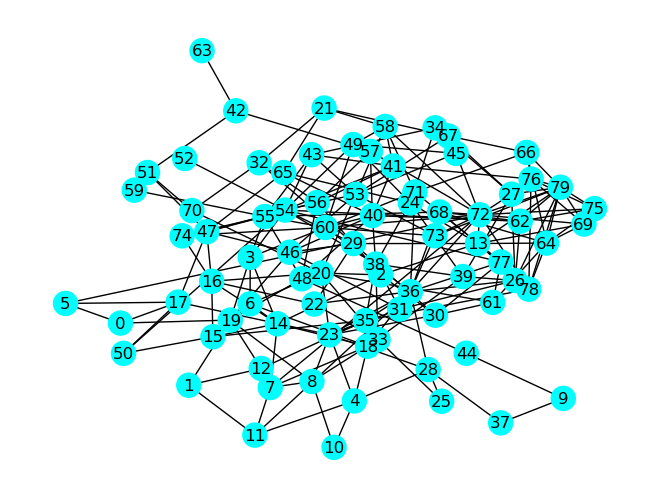

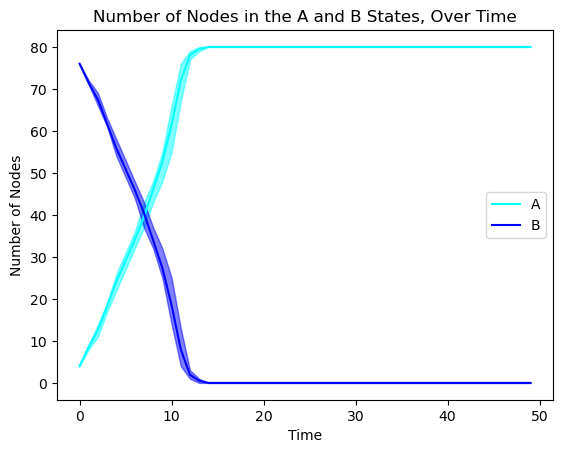

In [78]:
early_adopters = choose_early_adopters(graph_3.getGraph())
population = Population(lambda: add_edges(graph_3.getGraph(), early_adopters, reverse_betweenness=True), lambda _: early_adopters)
graph_3_sim = Simulation('graph_3', population, graph_3_handler.pos, n_trials=1000)
graph_3_sim.run()
graph_3_sim.plot(show_iqr=True)

In [81]:
graph_metrics(graph_3.getGraph())

Average clustering coefficient: 0.09921626984126984
Assortativity: 0.07715713975222857
Modularity: 0.45858949233536467
Average shortest path length: 3.07373417721519
Average degree: 4.825
Diameter: 7
Density: 0.06107594936708861


The graph metrics are shown in the cell directly above this one.  Additionally, we can see that, with the optimal parameters, complex contagion spreads to all of the network, on average (see the plots from two cells above this one); it also spreads relatively quickly (it reached peak infection after approximately 13-14 time steps, roughly the same as the previous graph).

Given the results for this graph, I will discuss my hypotheses:

<ol>
    <li> It again appears that the first hypothesis is incorrect.  The modularity for this graph (about 0.459) is similar to the modularity of the second graph.  However, like the first two graphs, modularity still seems relatively large.  I am still not completely sure as to why this hypothesis would be false, but if I had to speculate, I would say that choosing nodes with the largest centrality instead of influential nodes in each community is more effective due to how I am selecting edges.  In my edge selection process, I do not consider a non-adopter node's community, which is perhaps why an early adopter's community is insignificant (and it's better to simply choose adopters with the largest overall influence/centrality).
    <li> I did not test this hypothesis on this graph.
    <li> Once again, it appears that this hypothesis is incorrect.  However, for this graph, it appears that the order of edge traversal does not seem to have a significant impact.  Based on these findings, there is currently a toss up about which order seems to be more effective.  With the first graph, reverse order was more effective; with the second graph, regular order was more effective; with this graph, order does not seem to have much of an impact.
    <li> I did not test this hypothesis on this graph.
    <li> I did not test this hypothesis on this graph.
    <li> I did not test this hypothesis on this graph.
    <li> The final hypothesis does not apply to this graph (only the last two graphs).
</ol>

### Graph with 200 Edges, Lambda = 5, and Six Node Types

Similar to the previous graph, I will not test the second, fourth, fifth, and sixth hypotheses.  I am still curious about the first hypothesis, even though the first three graphs showed similar results (that the hypothesis is false).  Additionally, while the third hypothesis seems to be false, I still feel it warrants further exploration.  Finally, because this is the second-to-last graph, I will explore the final hypothesis.

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_13625/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


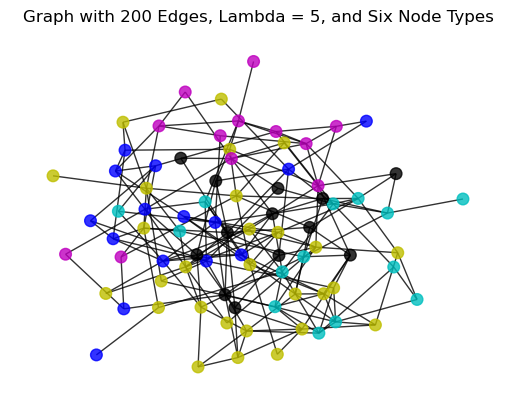

In [82]:
M = np.array([[0.8, 0.2, 0.2, 0.2, 0.2, 0.2],
              [0.2, 0.8, 0.2, 0.2, 0.2, 0.2],
              [0.2, 0.2, 0.8, 0.2, 0.2, 0.2],
              [0.2, 0.2, 0.2, 0.8, 0.2, 0.2],
              [0.2, 0.2, 0.2, 0.2, 0.8, 0.2],
              [0.2, 0.2, 0.2, 0.2, 0.2, 0.8]])
graph_4 = MixedNetworkFormation(M=M, poisson_lambda=5, num_edges=200)
graph_4_handler = graphHandler(graph_4.getGraph(), graph_4.getGroundTruthColors(), use_pydot=True)
graph_4_handler.showGraph(title='Graph with 200 Edges, Lambda = 5, and Six Node Types')

Early adopters by largest centrality value

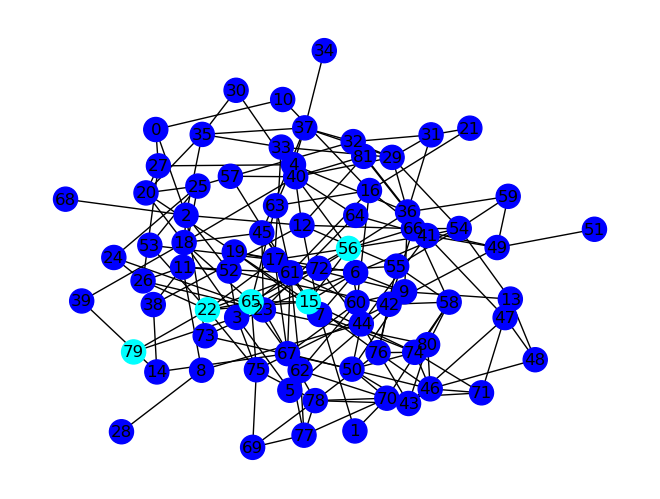

In [83]:
early_adopters = choose_early_adopters(graph_4.getGraph())
population = Population(graph_4.getGraph, lambda _: early_adopters)
graph_4_sim = Simulation('graph_4', population, graph_4_handler.pos)
graph_4_sim.run()

Early adopters by largest centrality value within communities

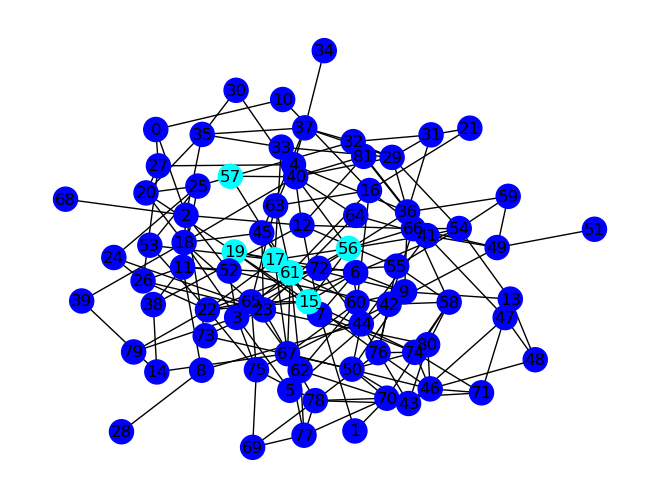

In [84]:
early_adopters = choose_early_adopters_by_community(graph_4.getGraph())
population = Population(graph_4.getGraph, lambda _: early_adopters)
graph_4_sim = Simulation('graph_4', population, graph_4_handler.pos)
graph_4_sim.run()

Check edges in regular betweenness order (i.e. edges with smaller betweenness values first)

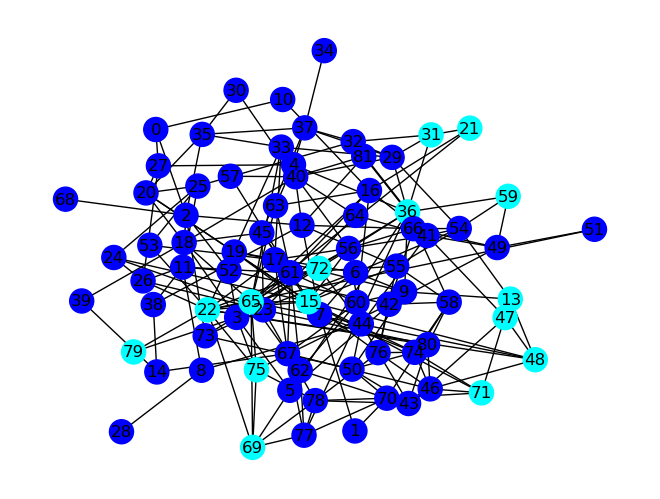

In [85]:
early_adopters = choose_early_adopters_by_community(graph_4.getGraph())
population = Population(lambda: add_edges(graph_4.getGraph(), early_adopters, reverse_betweenness=True), lambda _: early_adopters)
graph_4_sim = Simulation('graph_4', population, graph_4_handler.pos, n_trials=1000, n_iterations=50)
graph_4_sim.run()

Check edges in reverse betweenness order (i.e. edges with larger betweenness values first)

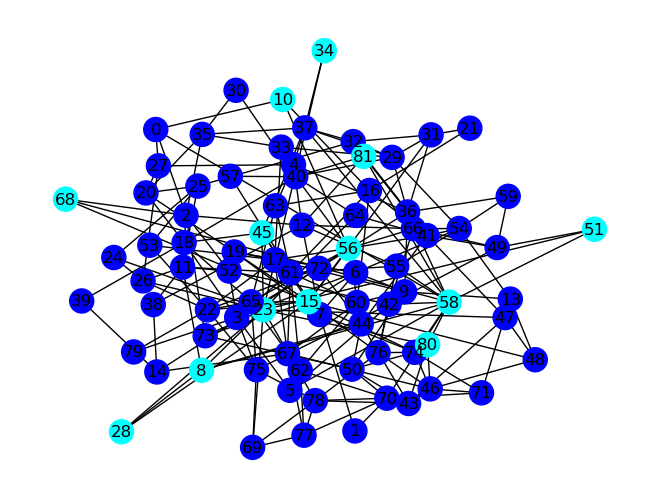

In [86]:
early_adopters = choose_early_adopters_by_community(graph_4.getGraph())
population = Population(lambda: add_edges(graph_4.getGraph(), early_adopters, reverse_betweenness=False), lambda _: early_adopters)
graph_4_sim = Simulation('graph_4', population, graph_4_handler.pos, n_trials=1000, n_iterations=50)
graph_4_sim.run()

Complex contagion definitely seems to be struggling; I will try using monte carlo sampling.

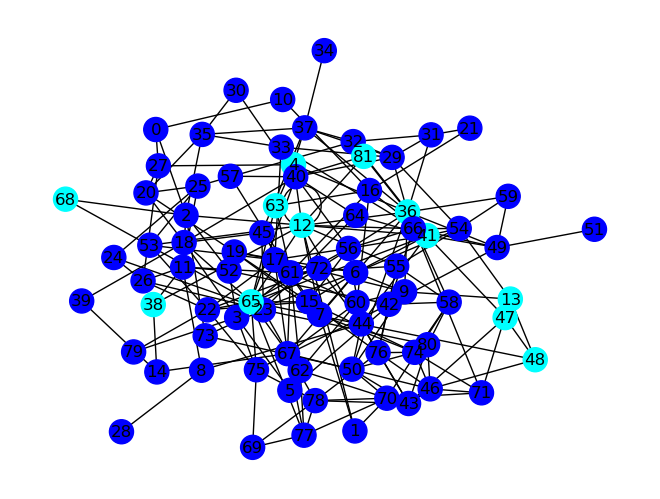

In [97]:
early_adopters = choose_early_adopters_by_community(graph_4.getGraph())
population = Population(lambda: monte_carlo(graph_4.getGraph(), early_adopters), lambda _: early_adopters)
graph_4_sim = Simulation('graph_4', population, graph_4_handler.pos, n_trials=1000, n_iterations=50)
graph_4_sim.run()

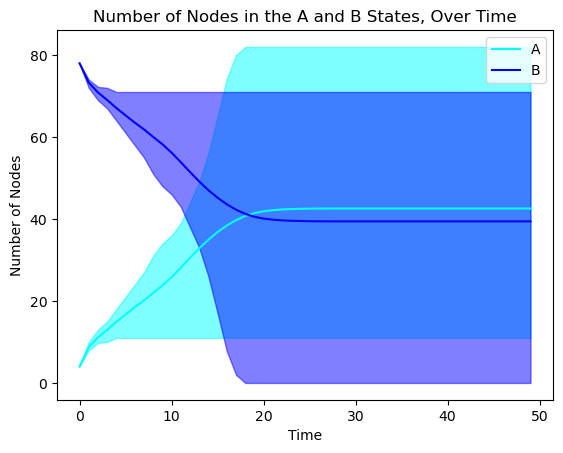

In [99]:
graph_4_sim.plot(show_iqr=True)

In [100]:
graph_metrics(graph_4.getGraph())

Average clustering coefficient: 0.07920054200542005
Assortativity: -0.12965964343597985
Modularity: 0.4292164064891338
Average shortest path length: 2.99608551641072
Average degree: 4.829268292682927
Diameter: 6
Density: 0.05962059620596206


The graph metrics are shown in the cell directly above this one.  Additionally, we can see that, with the optimal parameters, complex contagion spreads to roughly half of the network, on average (see the plots from two cells above this one).  We can also see that there are scenarios where it spreads to the entire network, though the uncertainty is much larger (due to the monte carlo sampling approach).  However, if needed, we could at least examine the scenarios where spread reaches every node in order to identify valuable/important edges.

Given the results for this graph, I will discuss my hypotheses:

<ol>
    <li> This is the first graph that seems to support the first hypothesis.  When using key adopters by community, 6 nodes adopted A instead of the 5 when we chose nodes with the largest overall centrality values.  However, this is admittedly not a significant difference; combined with the results from the previous three networks, I would say that this hypothesis still seems to be incorrect.
    <li> I did not test this hypothesis on this graph.
    <li> It appears that regular edge traversal was slightly more effective, which indicates that this hypothesis is false.
    <li> I did not test this hypothesis on this graph.
    <li> I did not test this hypothesis on this graph.
    <li> I did not test this hypothesis on this graph.
    <li> The final hypothesis appears to be correct.  It was more difficult to encourage complex contagion spread for this network.  Instead of using my default implementation, I had to use monte carlo sampling (not a very sophisticated approach for adding edges).
</ol>

### Graph with 300 Edges, Lambda = 10, and Six Node Types

Similar to the previous graph, I will not test the second, fourth, fifth, and sixth hypotheses.  Since I have tested the first and third hypotheses on every graph, I figure I might as well test them again on this final graph.  Because this is the last graph, I will explore the final hypothesis.

/var/folders/y1/r6lw81g960n148db75yhq7140000gn/T/ipykernel_13625/1583106224.py:6: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')


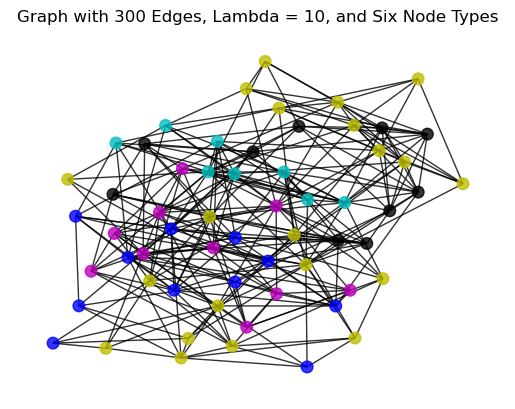

In [101]:
M = np.array([[0.8, 0.2, 0.2, 0.2, 0.2, 0.2],
              [0.2, 0.8, 0.2, 0.2, 0.2, 0.2],
              [0.2, 0.2, 0.8, 0.2, 0.2, 0.2],
              [0.2, 0.2, 0.2, 0.8, 0.2, 0.2],
              [0.2, 0.2, 0.2, 0.2, 0.8, 0.2],
              [0.2, 0.2, 0.2, 0.2, 0.2, 0.8]])
graph_5 = MixedNetworkFormation(M=M, poisson_lambda=10, num_edges=300)
graph_5_handler = graphHandler(graph_5.getGraph(), graph_5.getGroundTruthColors(), use_pydot=True)
graph_5_handler.showGraph(title='Graph with 300 Edges, Lambda = 10, and Six Node Types')

Early adopters by largest centrality value

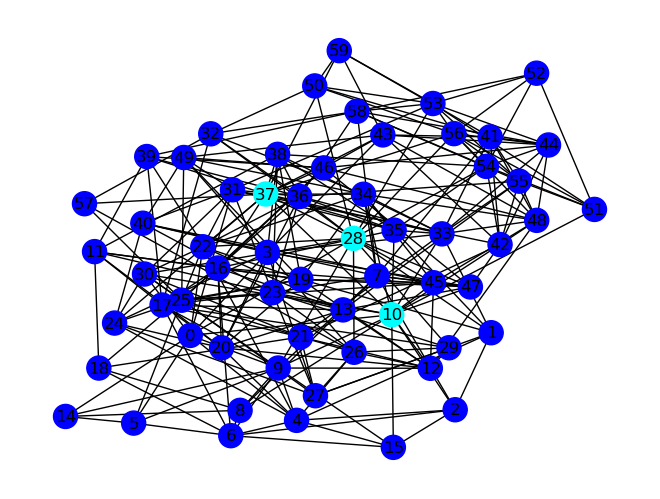

In [102]:
early_adopters = choose_early_adopters(graph_5.getGraph())
population = Population(graph_5.getGraph, lambda _: early_adopters)
graph_5_sim = Simulation('graph_5', population, graph_5_handler.pos)
graph_5_sim.run()

Early adopters by largest centrality value within communities

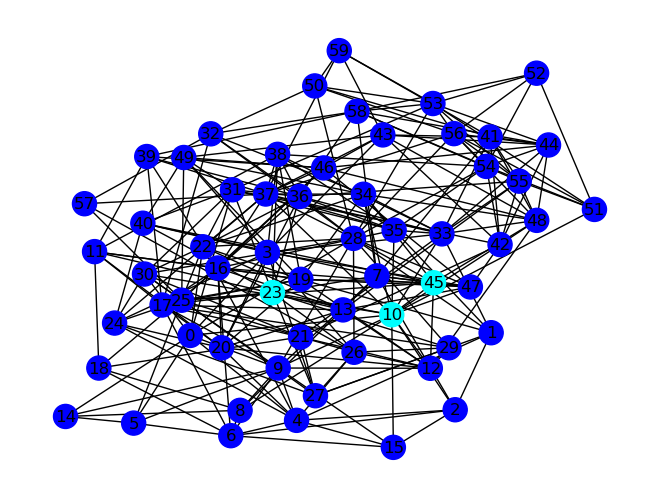

In [103]:
early_adopters = choose_early_adopters_by_community(graph_5.getGraph())
population = Population(graph_5.getGraph, lambda _: early_adopters)
graph_5_sim = Simulation('graph_5', population, graph_5_handler.pos)
graph_5_sim.run()

Check edges in regular betweenness order (i.e. edges with smaller betweenness values first)

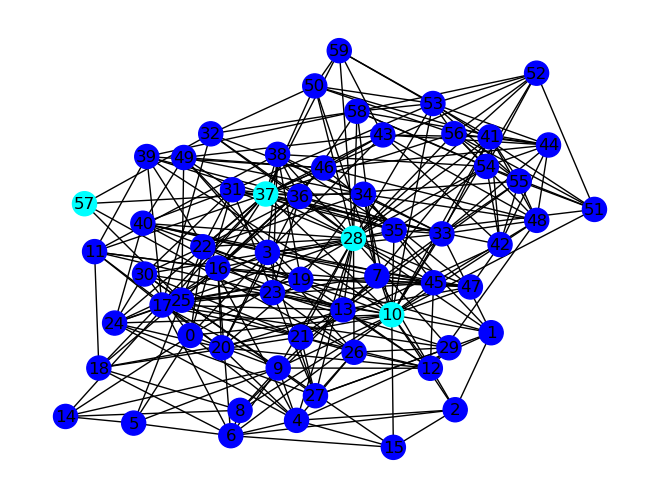

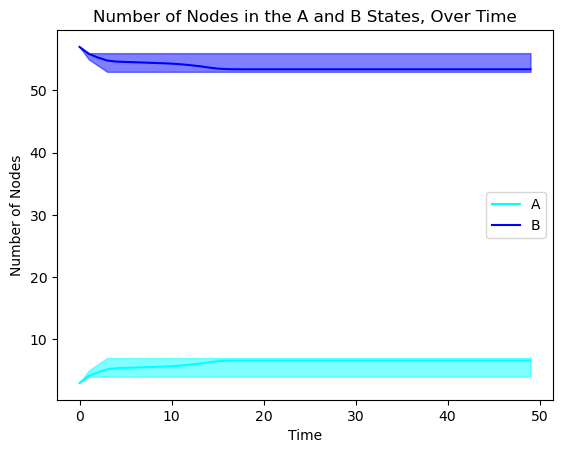

In [134]:
early_adopters = choose_early_adopters(graph_5.getGraph())
population = Population(lambda: add_edges(graph_5.getGraph(), early_adopters, reverse_betweenness=True), lambda _: early_adopters)
graph_5_sim = Simulation('graph_5', population, graph_5_handler.pos, n_trials=1000, n_iterations=50)
graph_5_sim.run()
graph_5_sim.plot(show_iqr=True)

Check edges in reverse betweenness order (i.e. edges with larger betweenness values first)

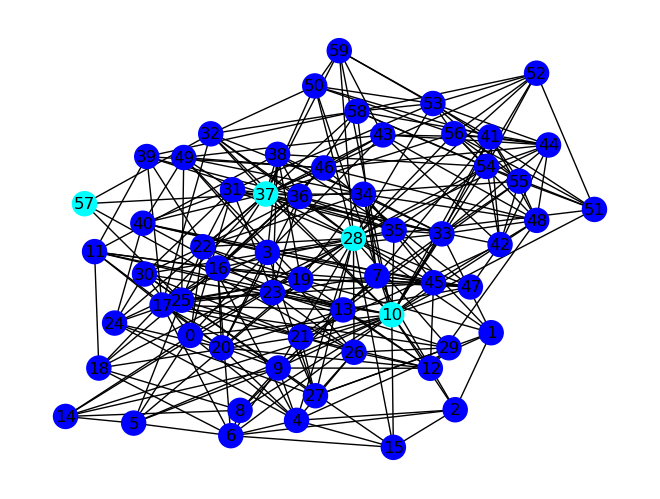

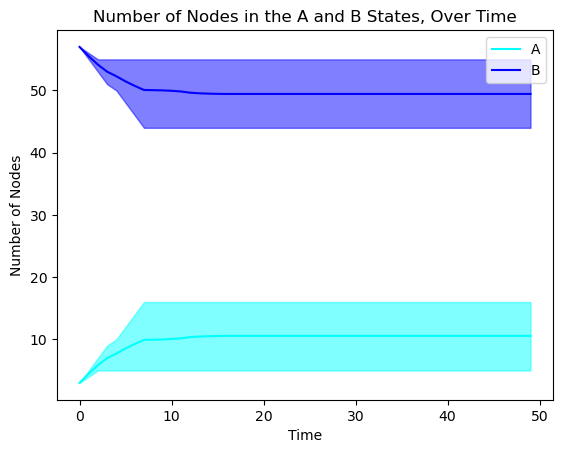

In [133]:
early_adopters = choose_early_adopters(graph_5.getGraph())
population = Population(lambda: add_edges(graph_5.getGraph(), early_adopters, reverse_betweenness=False), lambda _: early_adopters)
graph_5_sim = Simulation('graph_5', population, graph_5_handler.pos, n_trials=1000, n_iterations=50)
graph_5_sim.run()
graph_5_sim.plot(show_iqr=True)

Complex contagion definitely seems to be struggling; I will try using monte carlo sampling again.

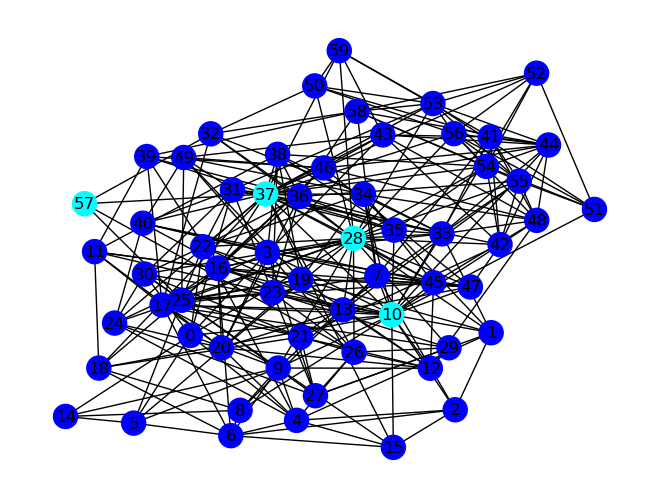

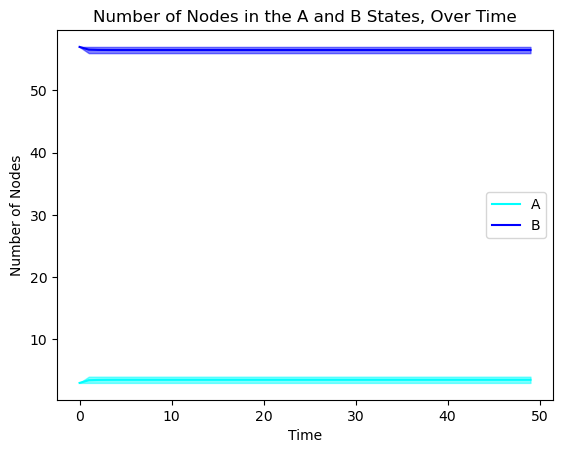

In [135]:
early_adopters = choose_early_adopters(graph_5.getGraph())
population = Population(lambda: monte_carlo(graph_5.getGraph(), early_adopters), lambda _: early_adopters)
graph_5_sim = Simulation('graph_5', population, graph_5_handler.pos, n_trials=1000, n_iterations=50)
graph_5_sim.run()
graph_5_sim.plot(show_iqr=True)

In [136]:
graph_metrics(graph_5.getGraph())

Average clustering coefficient: 0.2825516613016613
Assortativity: 0.001783090446087133
Modularity: 0.3406453476160471
Average shortest path length: 2.1361581920903956
Average degree: 9.2
Diameter: 4
Density: 0.15593220338983052


The graph metrics are shown in the cell directly above this one.  Additionally, we can see that, with the optimal parameters, complex contagion spreads to roughly 10 nodes, on average (the second time series IQR plot in this section).  For this network, monte carlo sampling did not seem to help.

Given the results for this graph, I will discuss my hypotheses:

<ol>
    <li> The two different approaches for selecting early adopters did not seem to impact the spread of contagion.  Again, it seems like this hypothesis is incorrect.
    <li> I did not test this hypothesis on this graph.
    <li> It appears that reverse edge traversal was more effective, which indicates that this hypothesis is true.
    <li> I did not test this hypothesis on this graph.
    <li> I did not test this hypothesis on this graph.
    <li> I did not test this hypothesis on this graph.
    <li> The final hypothesis appears to be correct.  It was very difficult to encourage complex contagion spread for this network, to the point where the best approach caused only 10 nodes to adopt A, on average.
</ol>

### Conclusion

Based on the results from the five different networks, I will summarize the findings for my hypotheses.

<ol>
    <li> Aside from the fourth graph, this hypothesis seemed to be false in every scenario.  Even with the fourth graph, contagion spread was only marginally better when early adopters were selected from distinct communities.  As I mentioned before, I would guess that choosing nodes with the largest centrality instead of influential nodes in each community is more effective due to how I am selecting edges (I don't consider communities).  Also, as I have had more time to think about this, we have the ability to link communities together through the process of adding edges.  Perhaps this is why getting early adopters in each community is not as valuable as simply using the overall most influential nodes.  Finally, the communities do not seem to be very tight-knit; we can see from the various graph metrics that, while modularity is positive in every scenario (indicating the existence of communities, as we would expect), the clustering coefficients are small, the densities are small, and the assortativity values are either negative or close to 0.  Based on my understanding of these metrics and complex contagion, it would seem that focusing on infilitrating every community is not the most valuable endeavor.
    <li> It appears that this hypothesis is also incorrect.  Weighting by centrality did not seem to impact the spread of complex contagion.  As I mentioned before, I would guess that the centrality weights are similar enough to the point where weighted random selection is very similar to uniform random sampling.  However, I would need to check the specific weight values to be sure.
    <li> It seems that this hypothesis is incorrect, though it is more of a toss up.  There were some graphs where traversing edges in reverse betweenness order was more effective (graphs one and five), and other graphs where regular traversal was more effective (graphs 2 and 4).  There was also one scenario where neither seemed to be very influential (graph 4).
    <li> This hypothesis is definitely false.  I originally thought that focusing on non-adopter nodes with large centrality values would be more valuable, but I see now that choosing nodes with smaller centrality values is evidently more effective.  This is probably because they require fewer links to early adopters in order to convert to A.  Furthermore, as these nodes convert, their neighbors are probably more likely to convert as well.
    <li> This hypothesis is incorrect, though not as much as the other incorrect hypotheses.  I originally thought that recalcuating graph metrics as edges are added would not have a significant impact on contagion spread.  However, it seemed to have either a neutral or negative effect on spread (plus it significantly increased compute time).
    <li> This hypothesis is one of the two that I feel are correct.  Since the graph is not small and we are only adding an extra 10% of the edges, there should be plenty of edges to consider (i.e. whether or not we consider an edge more than once should not have a significant impact on spread).
    <li> The final hypothesis, unsuprisingly, was correct.  Contagion spread was much more difficult to achieve on the final two graphs than the first three, due to the six distinct communities and the final graph's lambda of 10.
</ol>

Nearly all of my hypotheses were incorrect; I find it much more difficult to think about complex contagion than simple contagion.

### Future Work

There were a few things I thought of for this project, but did not have time for.  There was also one thing I wish I had done differently.  The items are as follows (in no particular order):

<ul>
    <li> I would have found it interesting to look at the monte carlo results that resulted in complete spread for graph four.  Perhaps the added edges would shed further light on how to effectively encourage complex contagion.
    <li> I did not want to do this for the project since it would have felt akin to "cheating", but one approach I thought of was to use the sequential nature of complex contagion to map out which edges to add.  For example, once the early adopters are selected, I could run a simulation to see which nodes get infected just from the adopters, then use that state of the contagion to choose the fewest number of edges required to infect more nodes, continue the simulation, etc.  In other words, iteratively run a complex contagion simulation and add edges once spread stops; if we ever run out of edges to add, then the process terminates.
    <li> Instead of monte carlo sampling, it would have been interesting to perform random walks starting from the early adopters in order to identify edges to add.
    <li> As I mentioned in my hypotheses discussion, I could have examined the weights for early adopter random sampling; my guess is that they were similar enough to the point where weighted random sampling was similar to uniform random sampling.
    <li> One thing I definitely wish I had done differently was work with a group on this project.  I have found complex contagion more difficult to reason about than simple contagion, so I feel that having at least one other teammate would have been beneficial.
</ul>